# E-studentski servis

##### Projekt pri predmetu Programiranje 1.<br>FMF, <br>Univerza v Ljubljani

### Julija Vorotnjak


Najprej naložimo potrebne knjižnjice.

In [1]:
# -*- coding: utf-8 -*-

In [2]:
from bs4 import BeautifulSoup
import requests 
import re
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
url = 'https://www.studentski-servis.com/index.php?t=prostaDela&hp=true&page=1&perPage=3016&sort=1&workType=1&keyword='
       
url_data=requests.get(url).content

soup = BeautifulSoup(url_data,'html.parser')

Z ukazom requests.get() s spletne strani poberemo html s željenimi podatki in jih shranimo v obliko BeautifulSoup.
Nato z ukazom soup.findAll() izluščimo željene podatke in jih zapišemo v sezname.

## SEZNAMI

Sezname nato združimo v en sam seznam **dataset**, čigar elementi so oblike **tuple**.

In [4]:
jobs = soup.findAll('div',{'class':'jobItem'})
ime = soup.findAll('span', {'class':'title'})
placa = soup.findAll('span',{'class':'postavka'})
lokacija = soup.findAll('span',{'class':'lokacija'})
opis = soup.findAll('div',{'class':'jobContent col'})
opiss= soup.findAll('p')
sifre=[]
for i in range(len(jobs)):
    sifra = jobs[i].li.parent.li.next_sibling.next_sibling.next_sibling.next_sibling.next_sibling.next_sibling
    sifre.append(sifra.text.strip('Šifra: ').strip(' |'))

dataset= [(s,i.text.strip('\n'),p.text.strip('\n').strip('\r\n\t\t\t\t\t').replace(',','.'),l.text.strip('\n'),op.text.replace('|\n','. ').replace('\n','').replace('\r','')) for s,i,p,l,op in zip( sifre,ime,placa,lokacija,opis)]
dataset

[('321429',
  'ZDRAVSTVENA NEGA',
  '5.49 €/h neto (6.50 €/h bruto)',
  'LJUBLJANA',
  'Zdravstvena nega na kirurškem hospitalnem oddelku. Pogoj: študent/ka zdravstvene fakultete, smer zdravstvena nega.Št. prostih mest: 1 . Trajanje: DLJE ČASA (OBČASNO) . Delovnik: Izmensko. Šifra: 321429 . Narava dela: začasno in občasno delo '),
 ('321428',
  'POUČEVANJEDELO Z OTROKI',
  '12.00 €/h neto (14.20 €/h bruto)',
  'MARIBOR',
  'Absolvent/ka anglistike ali germanistike. Potrebujejo osebo za poučevanje angleščine in/ali nemščine za predšolske otroke. Zaželene so izkušnje dela z otroki. Največ 3 ure tedensko, po potrebi in dogovoru. Pogoj je možnost lastnega prevoza do kraja izvajanja.Št. prostih mest: 2 . Trajanje: DLJE ČASA (OBČASNO) . Delovnik: Popoldan. Šifra: 321428 . Narava dela: začasno in občasno delo '),
 ('321427',
  'DELO V PROIZVODNJI',
  '5.49 €/h neto (6.50 €/h bruto)',
  'LJUBLJANA',
  'Podjetje išče resno, pridno, polnoletno osebo za delo v pripravi dela (delavnica) - montaža 

Zdaj, ko imamo podatke pripravljene, jih še zapišimo v *.csv* obliko. <br> V nadaljevanju bomo podatke pobirali iz naše sveže *.csv* datoteke.

Z funkcijo open odpremo datoteko **estudent.csv** v katero zapišemo podatke iz seznama **dataset**. 

In [5]:
with open('estudent.csv','w+',encoding='utf-8') as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerow(['sifra','naziv','placa','lokacija','opis'])
    for tuple in dataset:
        if tuple[0] is csvfile.read():
            None
        else:
            writer.writerow(tuple)



Sedaj zapisano datoteko odpremo in pričnemo z obdelavo podatkov.

In [6]:
data=pd.read_csv('estudent.csv')
pd.options.display.max_rows = 20
data

,sifra,naziv,placa,lokacija,opis
0,321429,ZDRAVSTVENA NEGA,5.49 €/h neto (6.50 €/h bruto),LJUBLJANA,Zdravstvena nega na kirurškem hospitalnem odde...
1,321428,POUČEVANJEDELO Z OTROKI,12.00 €/h neto (14.20 €/h bruto),MARIBOR,Absolvent/ka anglistike ali germanistike. Potr...
2,321427,DELO V PROIZVODNJI,5.49 €/h neto (6.50 €/h bruto),LJUBLJANA,"Podjetje išče resno, pridno, polnoletno osebo ..."
3,321426,DELO V PROIZVODNJI,5.49 €/h neto (6.50 €/h bruto),MENGEŠ,"Podjetje išče resno, pridno, polnoletno osebo ..."
4,321425,PREVAJANJE,8.45 €/h neto (10.00 €/h bruto),LJUBLJANA,Mlad kolektiv išče novo sodelavko(ca) z odličn...
...,...,...,...,...,...
993,275186,PROGRAMIRANJE,PO DOGOVORU/PROJEKTU...,LJUBLJANA,"Zaželeno poznavanje: PL/SQL, JAVASCRIPT, C,C++..."
994,270843,TRŽENJE,10.00 €/h neto (11.83 €/h bruto),DOLENJSKA,Promocija in trženje pri vnaprej dogovorjenih ...
995,270842,TRŽENJE,10.00 €/h neto (11.83 €/h bruto),ŠTAJERSKA,Promocija in trženje pri vnaprej dogovorjenih ...
996,270841,TRŽENJE,10.00 €/h neto (11.83 €/h bruto),LJUBLJANA Z OKOLICO,Promocija in trženje pri vnaprej dogovorjenih ...


Ker gledamo oglase s strani e-Študentskega servisa kot študent/ka, nas zanimajo samo **neto** postavke.<br> Prav tako ne potrebujemo oznake za valuto. 
<br> Dodamo stolpec **neto** kjer izluščimo samo neto postavko iz zapisa plače. Pri tem si pomagamo z regularnimi izrazi.

In [7]:
data['neto']=data['placa']
vzorec_neto = re.compile(r"(?P<neto>.*?) €\/h neto",flags=re.DOTALL)

vrednosti=[]
for i in range(len(data['neto'])):
    if re.findall(vzorec_neto,data['neto'][i]):
        vrednosti+=re.findall(vzorec_neto,data['neto'][i])
    else: vrednosti.append('0')
vrednosti
data['neto']=vrednosti
data['neto']=pd.to_numeric(data.neto)
data

,sifra,naziv,placa,lokacija,opis,neto
0,321429,ZDRAVSTVENA NEGA,5.49 €/h neto (6.50 €/h bruto),LJUBLJANA,Zdravstvena nega na kirurškem hospitalnem odde...,5.49
1,321428,POUČEVANJEDELO Z OTROKI,12.00 €/h neto (14.20 €/h bruto),MARIBOR,Absolvent/ka anglistike ali germanistike. Potr...,12.00
2,321427,DELO V PROIZVODNJI,5.49 €/h neto (6.50 €/h bruto),LJUBLJANA,"Podjetje išče resno, pridno, polnoletno osebo ...",5.49
3,321426,DELO V PROIZVODNJI,5.49 €/h neto (6.50 €/h bruto),MENGEŠ,"Podjetje išče resno, pridno, polnoletno osebo ...",5.49
4,321425,PREVAJANJE,8.45 €/h neto (10.00 €/h bruto),LJUBLJANA,Mlad kolektiv išče novo sodelavko(ca) z odličn...,8.45
...,...,...,...,...,...,...
993,275186,PROGRAMIRANJE,PO DOGOVORU/PROJEKTU...,LJUBLJANA,"Zaželeno poznavanje: PL/SQL, JAVASCRIPT, C,C++...",0.00
994,270843,TRŽENJE,10.00 €/h neto (11.83 €/h bruto),DOLENJSKA,Promocija in trženje pri vnaprej dogovorjenih ...,10.00
995,270842,TRŽENJE,10.00 €/h neto (11.83 €/h bruto),ŠTAJERSKA,Promocija in trženje pri vnaprej dogovorjenih ...,10.00
996,270841,TRŽENJE,10.00 €/h neto (11.83 €/h bruto),LJUBLJANA Z OKOLICO,Promocija in trženje pri vnaprej dogovorjenih ...,10.00


Ker želimo videti, kako so razporejene postavke po lokacijah in vrstah dela (t.j. stolpec naziv), stolpca plača in opis odstranimo.

Prav tako nas zanimajo samo oglasi, kjer je neto postavka določena, zato izločimo ostale. Novo tabelo poimenujemo *coredf*.

In [8]:
df=data[['sifra','naziv','lokacija','neto']]
coredf=df[df.neto !=0]
coredf

,sifra,naziv,lokacija,neto
0,321429,ZDRAVSTVENA NEGA,LJUBLJANA,5.49
1,321428,POUČEVANJEDELO Z OTROKI,MARIBOR,12.00
2,321427,DELO V PROIZVODNJI,LJUBLJANA,5.49
3,321426,DELO V PROIZVODNJI,MENGEŠ,5.49
4,321425,PREVAJANJE,LJUBLJANA,8.45
...,...,...,...,...
991,286805,FIZIČNA DELA,RADOMLJE,4.65
994,270843,TRŽENJE,DOLENJSKA,10.00
995,270842,TRŽENJE,ŠTAJERSKA,10.00
996,270841,TRŽENJE,LJUBLJANA Z OKOLICO,10.00


 Izbrisali smo vse oglase, ki nimajo podane neto plače.<br>
 Poglejmo sedaj koliko je oglasov razpisanih po različnih krajih. Uporabimo funkcijo **.groupby()** in nato **pandas.to_numeric()** da so dobljene vrednosti numerične.

In [9]:
po_mestih=coredf.groupby('lokacija')['naziv'].count()
po_mestih=pd.to_numeric(po_mestih)
po_mestih=pd.DataFrame({'število oglasov': po_mestih}).reset_index()
po_mestih

,lokacija,število oglasov
0,ADLEŠIČI,1
1,ANAKRAN,2
2,ANDREJCI,1
3,ANKARAN,1
4,APAČE,2
...,...,...
311,ŠMARTNO PRI LITIJI,3
312,ŠTAJERSKA,1
313,ŽEJE PRI KOMENDI,1
314,ŽUSTERNA,1


Poglejmo si kako izgleda graf razporeditve oglasov po mestih.<br> Za risanje grafov bomo uporabili knjižnjici ***matplotlib*** in ***seaborn***.

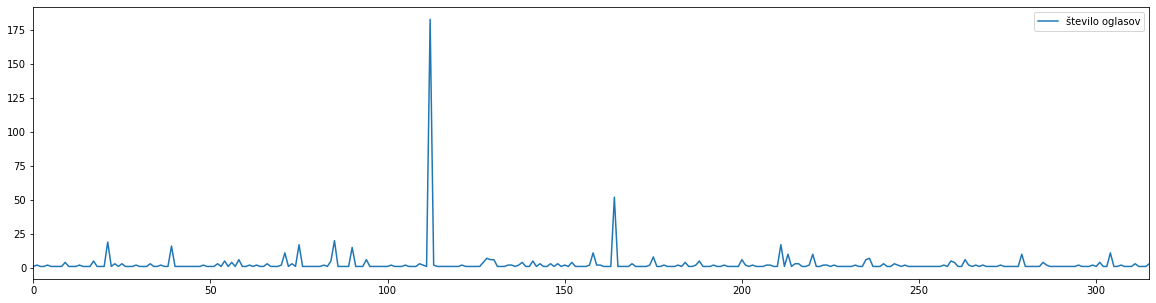

In [10]:
po_mestih.plot( y='število oglasov', kind = 'line', figsize=(20,5))

Funkcija **.plot()** za absciso avtomatično vzame številko vrstice v tabeli (angl.: index), zaradi preglednosti na absciso postavimo še nekaj lokacij.

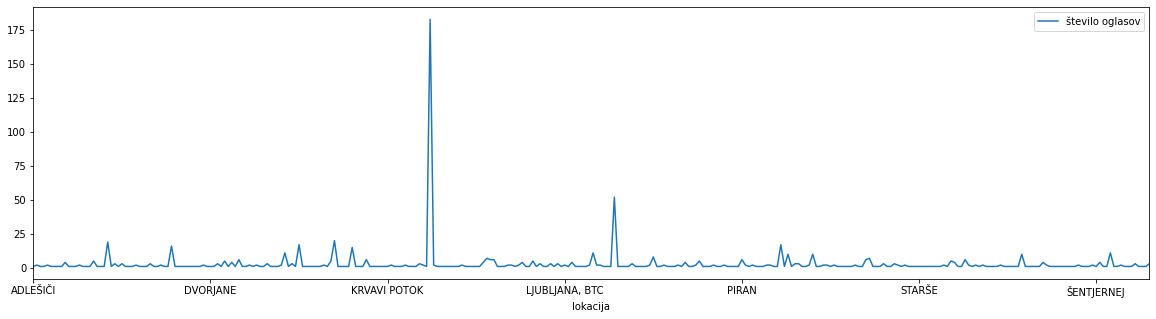

In [11]:
po_mestih.plot( x='lokacija', y='število oglasov', kind = 'line', figsize=(20,5))

Poglejmo sedaj po posameznih krajih kolikšne so največja  in najmanjša postavka. <br>Pripišimo še stolpec s številom oglasov v vsakem kraju. 

In [12]:
po_mestih_po_placah=coredf.groupby('lokacija')['neto'].agg(['count','min','max'])
po_mestih_po_placah

,count,min,max
lokacija,,,
ADLEŠIČI,1,5.50,5.50
ANAKRAN,2,5.50,6.00
ANDREJCI,1,8.45,8.45
ANKARAN,1,6.50,6.50
APAČE,2,7.00,7.00
...,...,...,...
ŠMARTNO PRI LITIJI,3,5.00,5.00
ŠTAJERSKA,1,10.00,10.00
ŽEJE PRI KOMENDI,1,5.07,5.07


Poglejmo sedaj še kolikšna je povprečna neto postavka v posameznem kraju.<br> Uporabimo funkcijo **.mean()**.

In [13]:
povp_po_mestih= round(coredf.groupby('lokacija')['neto'].mean(),2)
povp_po_mestih = pd.DataFrame({'povp neto' : povp_po_mestih}).reset_index()
povp_po_mestih

,lokacija,povp neto
0,ADLEŠIČI,5.50
1,ANAKRAN,5.75
2,ANDREJCI,8.45
3,ANKARAN,6.50
4,APAČE,7.00
...,...,...
311,ŠMARTNO PRI LITIJI,5.00
312,ŠTAJERSKA,10.00
313,ŽEJE PRI KOMENDI,5.07
314,ŽUSTERNA,6.00


Narišimo še graf povprečnih neto postavk po krajih.<br> Tu bi bralec lahko uprabil tudi *plotly* knjižnjico, ki omogoča interaktivni graf in bi lahko po njemu tudi pogledali natančne točke.

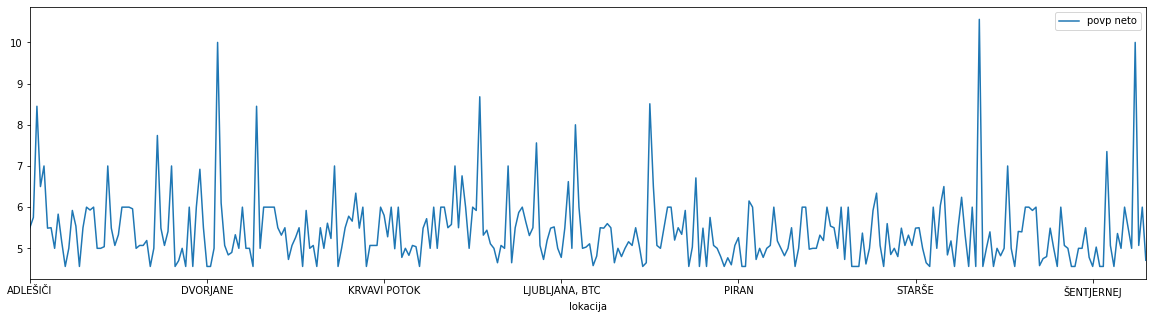

In [14]:
povp_po_mestih.plot(x='lokacija', y='povp neto', kind = 'line', figsize=(20,5))

Kot mladi iskalci zaposlitve, nas zanima katero delo, v katerem kraju za nas v povprečju ponuja največjo postavko.<br>Zanimajo nas samo bolje plačana dela, zato izločimo vsa dela kjer je urna neto postavka manjša ali enaka 5€.
<br> Zapišemo tabelo  povprečnih postavk po vrstah dela (t.j. naziv) in po krajih (t.j. lokacija).
Naredimo nov *DataFrame*, da lahko lažje rišemo grafe.

In [15]:
b= coredf[coredf.neto>5]
bb=round(b.groupby(['lokacija','naziv'])['neto'].mean(),2)
bb = pd.DataFrame({'povp neto' : bb}).reset_index()
bb

,lokacija,naziv,povp neto
0,ADLEŠIČI,STREŽBA HRANE IN PIJAČE,5.50
1,ANAKRAN,POMOČ V KUHINJIPOMIVALEC,5.50
2,ANAKRAN,STREŽBADELO NA RECEPCIJI,6.00
3,ANDREJCI,LAŽJA FIZIČNA DELADELO Z ŽIVALMI,8.45
4,ANKARAN,STREŽBA,6.50
...,...,...,...
352,ŠMARJE SAP,POMOČ V STREŽBI,6.00
353,ŠMARTNO OB PAKI,STROKOVNO DELOTESTIRANJE,5.50
354,ŠTAJERSKA,TRŽENJE,10.00
355,ŽEJE PRI KOMENDI,LAŽJA FIZIČNA DELADELO V PROIZVODNJI,5.07


Graf tokrat narišemo s knjižnjico **seaborn**.

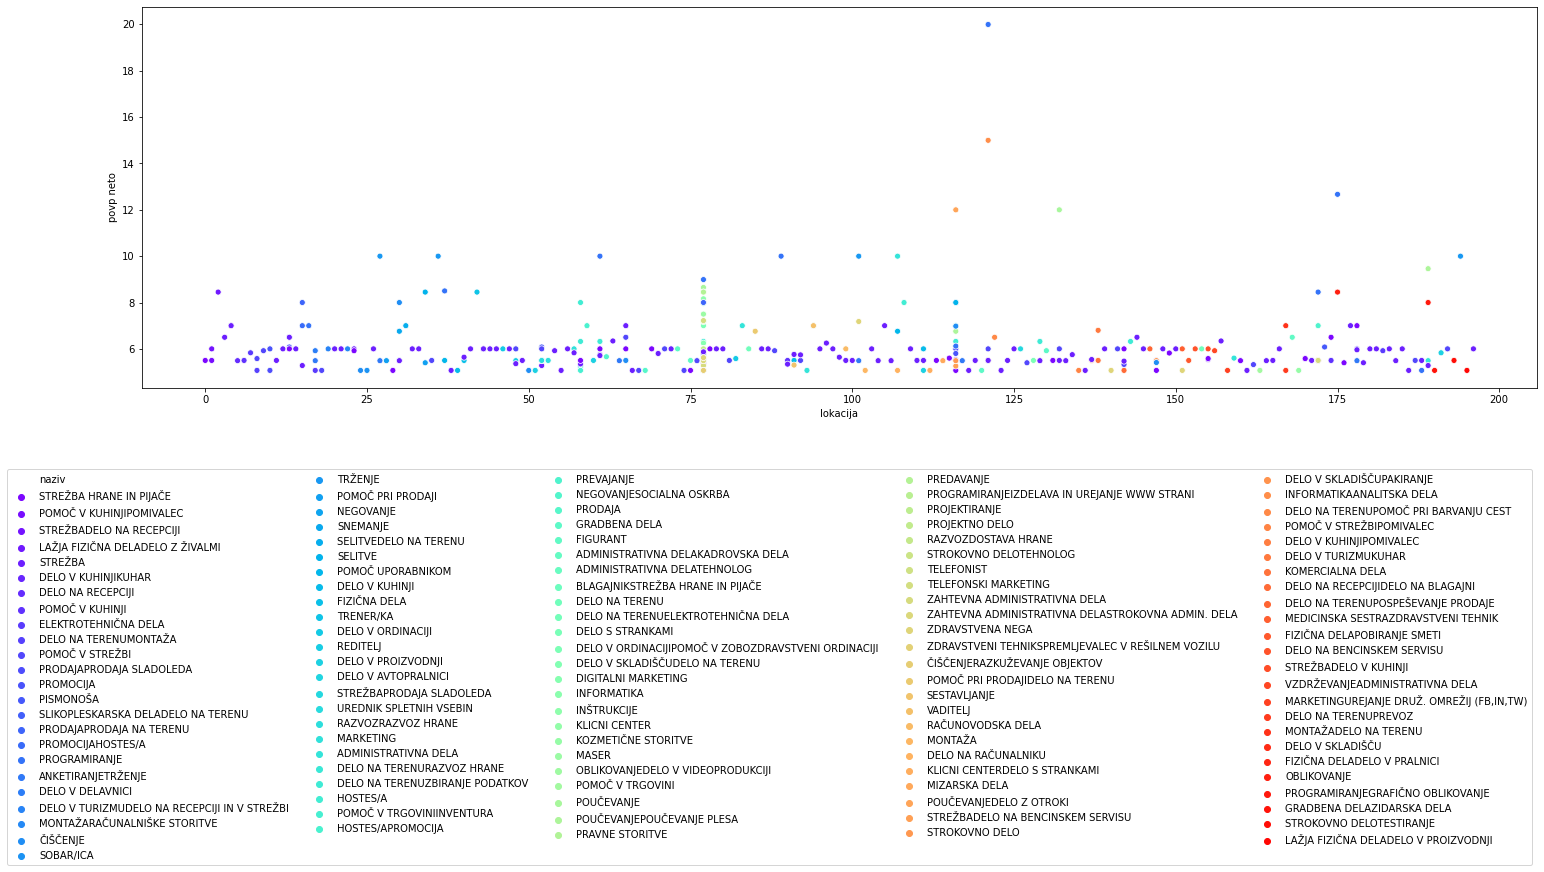

In [16]:
f, ax = plt.subplots(figsize=(25, 7))
g =sns.scatterplot(x='lokacija', y='povp neto',hue='naziv',data=bb , palette='rainbow',)
g.set(xscale='linear')
g.legend(bbox_to_anchor=(1,-0.2), ncol=5)

Pri tolikšni količini podatkov, je težko karkoli najti dober oglas, zato se osredotočimo na oglase za **PROGRAMIRANJE**. Zapišimo tabelo in narišimo graf.

In [17]:
c=coredf[coredf.eq('PROGRAMIRANJE').any(1)]
c

/usr/lib64/python3.8/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,sifra,naziv,lokacija,neto
58,321361,PROGRAMIRANJE,LJUBLJANA - ŠIŠKA,10.00
59,321360,PROGRAMIRANJE,LJUBLJANA - ŠIŠKA,10.00
60,321359,PROGRAMIRANJE,LJUBLJANA - ŠIŠKA,10.00
74,321336,PROGRAMIRANJE,ŠENTJUR,5.07
206,321070,PROGRAMIRANJE,KRANJ,10.00
...,...,...,...,...
910,314440,PROGRAMIRANJE,MENGEŠ,20.00
922,313512,PROGRAMIRANJE,LJUBLJANA,6.40
929,313057,PROGRAMIRANJE,LJUBLJANA,7.61
975,297335,PROGRAMIRANJE,TRZIN,8.45


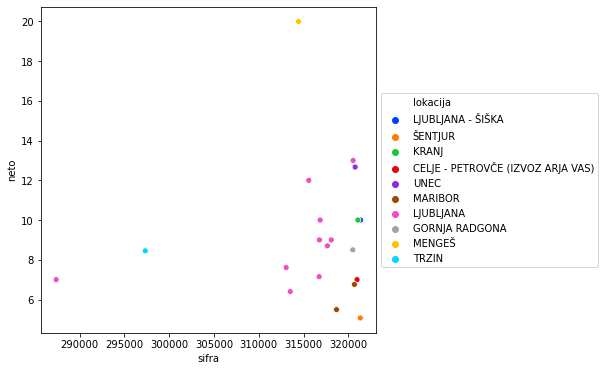

In [18]:
f, ax = plt.subplots(figsize=(6,6 ))
l=sns.scatterplot(x='sifra', y='neto',data=c, hue='lokacija', palette= 'bright')
l.legend(bbox_to_anchor=(1,0.75), ncol=1)

Iz grafa je razvidno da je veliko oglasov za programiranje objavljeno v Ljubljani. <br>Poglejmo natančneje te oglase. Pri tem upoštevamo oglase z krajem *LJUBLJANA* in *LJUBLJANA-ŠIŠKA*.

In [19]:
a=c[c.eq('LJUBLJANA - ŠIŠKA').any(1)].append(c[c.eq('LJUBLJANA').any(1)] )# vse programerske službe v ljubljani ('LJUBLJANA' in 'LJUBLJANA-ŠIŠKA')
a

,sifra,naziv,lokacija,neto
58,321361,PROGRAMIRANJE,LJUBLJANA - ŠIŠKA,10.00
59,321360,PROGRAMIRANJE,LJUBLJANA - ŠIŠKA,10.00
60,321359,PROGRAMIRANJE,LJUBLJANA - ŠIŠKA,10.00
366,320532,PROGRAMIRANJE,LJUBLJANA,13.00
746,318094,PROGRAMIRANJE,LJUBLJANA,9.00
810,317660,PROGRAMIRANJE,LJUBLJANA,8.70
891,316853,PROGRAMIRANJE,LJUBLJANA,10.00
892,316770,PROGRAMIRANJE,LJUBLJANA,9.00
893,316740,PROGRAMIRANJE,LJUBLJANA,7.15
904,315583,PROGRAMIRANJE,LJUBLJANA,12.00


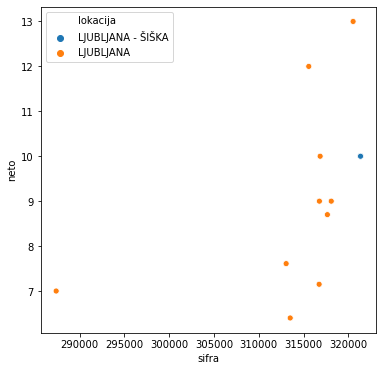

In [20]:
f, ax = plt.subplots(figsize=(6,6 ))
sns.scatterplot(data = a,x='sifra',y='neto', hue='lokacija')

Našli smo vse oglase z nazivom 'PROGRAMIRANJE' v Ljubljani. Vidimo da je najvišja postavka 13€/h, večinoma pa se postavke gibajo med 8€/h in 10€/h. Sedaj smo omejili izbor in si lahko oglase natančneje pogledamo.<br> Poglejmo si natančneje oglas pod šifro ***cifra***.

In [34]:
cifra=313057
oglas=data[data.sifra==cifra]
oglas

,sifra,naziv,placa,lokacija,opis,neto
929,313057,PROGRAMIRANJE,7.61 €/h neto (9.00 €/h bruto),LJUBLJANA,"Iščejo Java programerje, ki bodo sodelovali z ...",7.61


In [47]:
oglas.opis

929    Iščejo Java programerje, ki bodo sodelovali z ...
Name: opis, dtype: object

In še natančen opis dela, ki ga dobimo iz osnovne oblike zapisa :

In [50]:
for (s,n,p,l,op) in zip(oglas.sifra,oglas.naziv,oglas.placa,oglas.lokacija,oglas.opis):
    oglass=(s,n,p,l,op)
oglass



(313057,
 'PROGRAMIRANJE',
 '7.61 €/h neto (9.00 €/h bruto)',
 'LJUBLJANA',
 'Iščejo Java programerje, ki bodo sodelovali z razvojno skupino, odgovorno za razvoj kompleksne aplikativne programske opreme. Pričakujejo osnovno znanje objektnega programiranja v Javi in poznavanje osnov konceptov tri nivojske arhitekture. Zaželeni študenti zadnjega letnika Fakultete za računalništvo in informatiko (1. ali 2. bolonjska stopnja).Št. prostih mest: 3 . Trajanje: PO DOGOVORU, DLJE ČASA . Delovnik: vseeno. Šifra: 313057 . Narava dela: začasno in občasno delo ')

Sedaj lahko mirno spimo, saj smo našli željeno delo.